In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot
import awkward as ak
import seaborn as sn
from fast_histogram import histogram2d

In [15]:
#data_path = "/disk/atlas3/data_MC/ATLASOpen/jets/part1.root" 
bkg_data_path = "../../Delphes-3.5.0/ttbar_13TeV_taus.root:Delphes" 
signal_data_path = "../../Delphes-3.5.0/directW_13TeV_taus.root:Delphes" 
#data_path = "../../Delphes-3.5.0/directW_13TeV.root:Delphes" 

These are some examples of how to look at root files using uproot and awkward arrays. More info in this tutorial:
https://hub.gke2.mybinder.org/user/jpivarski-2020--ep2020-tutorial-7h7oraqf/lab/tree/tutorial.ipynb


In [16]:
def cal_image_plot(ax):
    """
    Formating of calorimeter image
    """
    ax.set_ylabel(r"$\phi$ [radians]]", fontsize=16)
    ax.set_xlabel(r"$\eta$", fontsize=16)
    #ax.set_title("Calorimeter image", fontsize=20, color="black")
    ax.tick_params(which="both", direction="inout", top=True, right=True, labelsize=14, pad=15, length=4, width=2)
    ax.tick_params(which="major", length=8)
    ax.tick_params(which="major", length=6)
    ax.minorticks_on()

def zero_to_nan(arr):
    """
    converts the zeros to NaN to avoid confusion
    """
    clusters = arr.clusters
    clusters.E = ak.where(clusters.E == 0, np.nan, clusters.E)
    clusters.x = ak.where(clusters.x == 0, np.nan, clusters.x)
    clusters.y = ak.where(clusters.y == 0, np.nan, clusters.y)
    clusters.z = ak.where(clusters.z == 0, np.nan, clusters.z)
    arr.clusters = clusters
    return arr

def cartesian_to_angles(arr, drop:bool=False):
    """
    converts cartesian coordinates to polar angles
    """
    clusters = arr.clusters
    clusters["pT"] = np.sqrt(clusters.x**2 + clusters.y**2)
    clusters["eta"] = np.arcsinh(clusters.z/clusters["pT"])
    clusters["phi"] = np.arcsin(clusters.y/clusters["pT"])
    """
    Add this functionality: drop old values
    if drop:
    """
    arr.clusters = clusters
    return arr

In [17]:
#Open file in with-function will close it when you exit
def look(rootfile:str):
    with uproot.open(rootfile) as file:
        keys = file.keys()
        #print(keys)
        #print(file.show())
        print(file["Tower"].keys())
        #print(file["Tower"]["Tower.ET"].array())

def load_data(rootfile:str, branch:str, keys:list):
    with uproot.open(rootfile) as file:
        valid_list = [key in file.keys() for key in keys]
        if valid_list:
            arr = file[branch].arrays(keys, library="ak", how="zip")
            return arr[branch]
        else:
            print(keys[not(valid_list)], " not present in data.")


#look(data_path)
bkg_clusters = load_data(bkg_data_path, "Tower", ["Tower.ET", "Tower.Eta", "Tower.Phi", "Tower.Eem", "Tower.Ehad"])
signal_clusters = load_data(signal_data_path, "Tower", ["Tower.ET", "Tower.Eta", "Tower.Phi", "Tower.Eem", "Tower.Ehad"])
#print(ak.to_list(clusters[0]))
max_hits = np.max([len(item) for item in bkg_clusters["ET"]])
print(max_hits)
bkg_clusters = ak.pad_none(bkg_clusters, max_hits, axis=-1)
signal_clusters = ak.pad_none(signal_clusters, max_hits, axis=-1)

489


In [29]:
print(ak.type(bkg_clusters))
print(ak.type(signal_clusters))

1000 * var * ?{"ET": float32, "Eta": float32, "Phi": float32, "Eem": float32, "Ehad": float32}
1000 * var * ?{"ET": float32, "Eta": float32, "Phi": float32, "Eem": float32, "Ehad": float32}


In [6]:
#clusters["EZ"] = clusters["ET"]*np.sinh(clusters["Eta"])
#clusters["EX"] = clusters["ET"]*np.cos(clusters["Phi"])
#clusters["EY"] = clusters["ET"]*np.sin(clusters["Phi"])

In [18]:
#Extracting data for plotting
bkg_largest_ET = ak.argmax(bkg_clusters.ET, axis=-1, keepdims=True)
bkg_eta = ak.to_list(ak.flatten(bkg_clusters.Eta[bkg_largest_ET]))
bkg_phi = ak.to_list(ak.flatten(bkg_clusters.Phi[bkg_largest_ET]))
bkg_ET = ak.to_list(ak.flatten(bkg_clusters.ET[bkg_largest_ET]))

signal_largest_ET = ak.argmax(signal_clusters.ET, axis=-1, keepdims=True)
signal_eta = ak.to_list(ak.flatten(signal_clusters.Eta[signal_largest_ET]))
signal_phi = ak.to_list(ak.flatten(signal_clusters.Phi[signal_largest_ET]))
signal_ET = ak.to_list(ak.flatten(signal_clusters.ET[signal_largest_ET]))

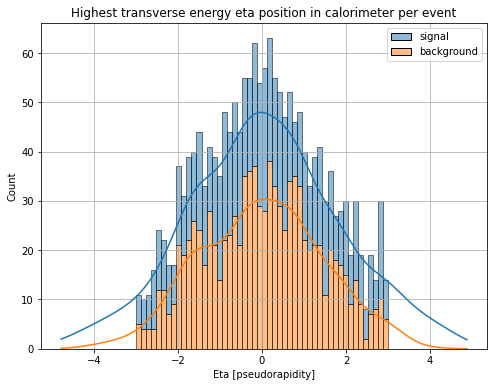

In [21]:
#Eta distribution
fig, ax = plt.subplots(figsize=(8,6))
sn.histplot({"signal": signal_eta, "background": bkg_eta}, ax = ax, bins=50, binrange=[-3,3], kde=True, multiple="stack", stat="count")
ax.set_title("Highest transverse energy eta position in calorimeter per event")
ax.set_xlabel("Eta [pseudorapidity]")
#ax.set_yscale('log')
ax.grid(visible=None)

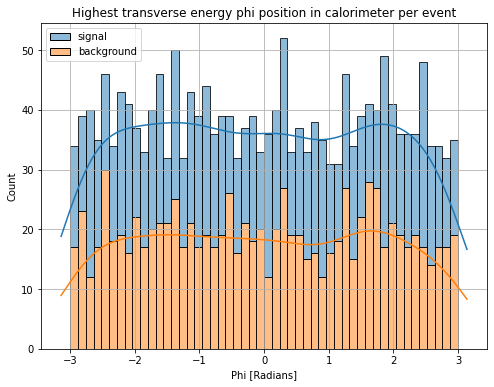

In [22]:
#Phi distribution, should be uniform
fig, ax = plt.subplots(figsize=(8,6))
sn.histplot({"signal": signal_phi, "background": bkg_phi}, ax = ax, bins=50, binrange=[-3,3], kde=True, multiple="stack", stat="count")
ax.set_title("Highest transverse energy phi position in calorimeter per event")
ax.set_xlabel("Phi [Radians]")
#ax.set_yscale('log')
ax.grid(visible=None)

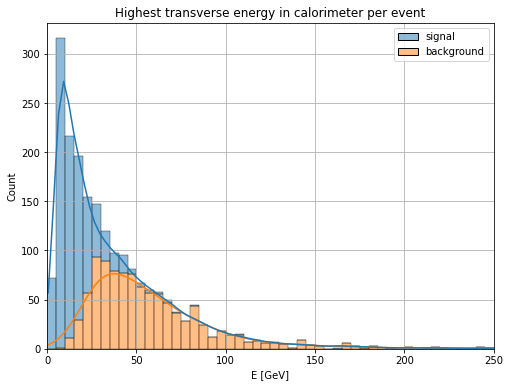

In [34]:
#Energy distribution
fig, ax = plt.subplots(figsize=(8,6))
sn.histplot({"signal": signal_ET, "background": bkg_ET}, ax = ax, bins=50, binrange=[0,250], kde=True, multiple="stack", stat="count")
ax.set_title("Highest transverse energy in calorimeter per event")
ax.set_xlabel("E [GeV]")
ax.set_xlim(0, 250)
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.grid(visible=None)

In [36]:
#Converting to images
MAX_EVENTS = 100
RESOLUTION = 80

def create_histograms(x, y, z):
    max_available_events = len(x)
    if max_available_events < MAX_EVENTS:
        max_events = max_available_events
    else: max_events = MAX_EVENTS
    Cal = [histogram2d(y[i], x[i], 
            range=[[-np.pi, np.pi], [-2.5, 2.5]], bins=RESOLUTION, 
            weights=z[i]) 
            for i in range(0, max_events)]
    #Cal = [histogram2d(event.phi, event.eta, range=[[-np.pi, np.pi], [-2.5, 2.5]], bins=RESOLUTION) for event in array[:max_events]]
    return Cal


hists = create_histograms(ak.to_numpy(signal_clusters.Phi), ak.to_numpy(signal_clusters.Eta), ak.to_numpy(signal_clusters.ET))

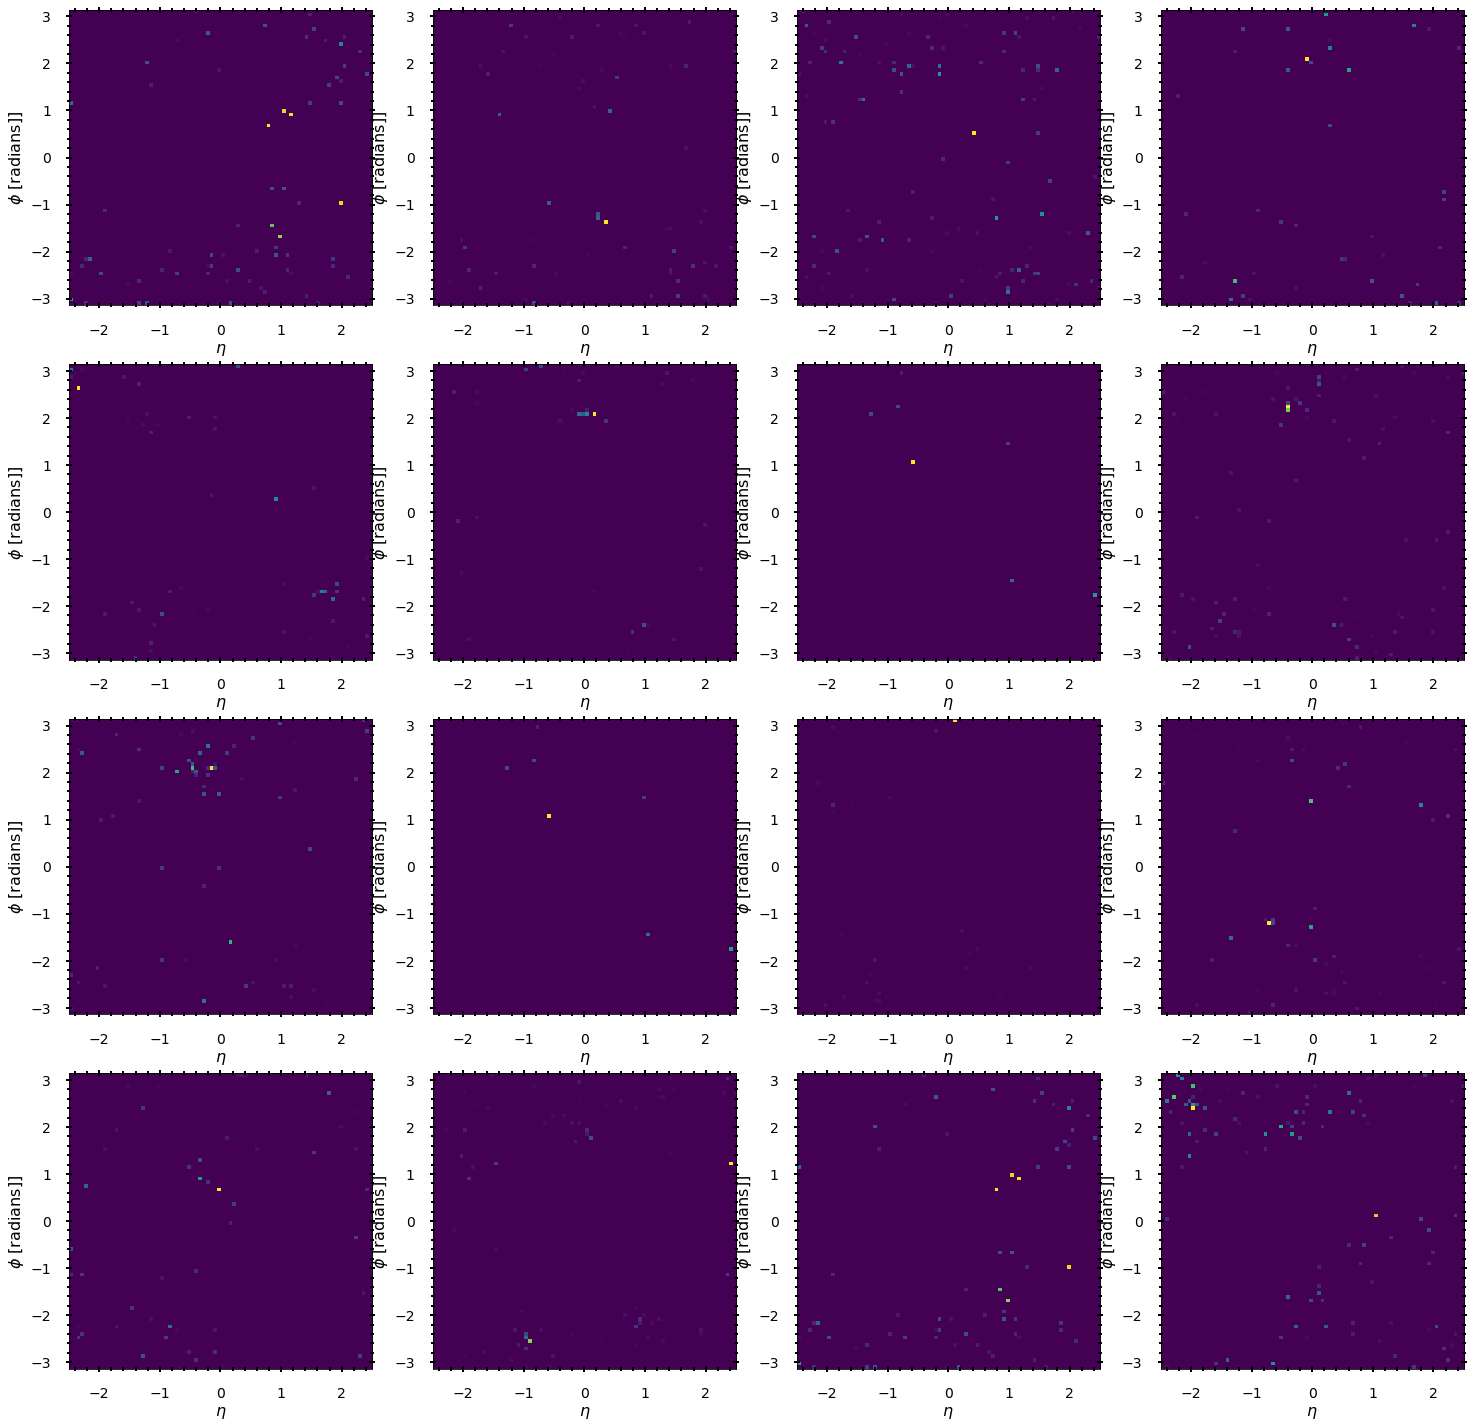

In [37]:
fig, axs = plt.subplots(nrows = 4, ncols = 4, figsize = (25,25))
images = np.random.randint(0, high=len(hists), size=(4,4))
for i in range(4):
    for j in range(4):
        cal_image_plot(axs[i][j])
        axs[i][j].imshow(hists[images[i][j]], extent=[-2.5, 2.5, -np.pi, np.pi], aspect='auto')

In [38]:
#Converting to images
MAX_EVENTS = 100
RESOLUTION = 80

def create_histograms(x, y, z):
    max_available_events = len(x)
    if max_available_events < MAX_EVENTS:
        max_events = max_available_events
    else: max_events = MAX_EVENTS
    Cal = [histogram2d(y[i], x[i], 
            range=[[-np.pi, np.pi], [-2.5, 2.5]], bins=RESOLUTION, 
            weights=z[i]) 
            for i in range(0, max_events)]
    #Cal = [histogram2d(event.phi, event.eta, range=[[-np.pi, np.pi], [-2.5, 2.5]], bins=RESOLUTION) for event in array[:max_events]]
    return Cal


hists = create_histograms(ak.to_numpy(bkg_clusters.Phi), ak.to_numpy(bkg_clusters.Eta), ak.to_numpy(bkg_clusters.ET))

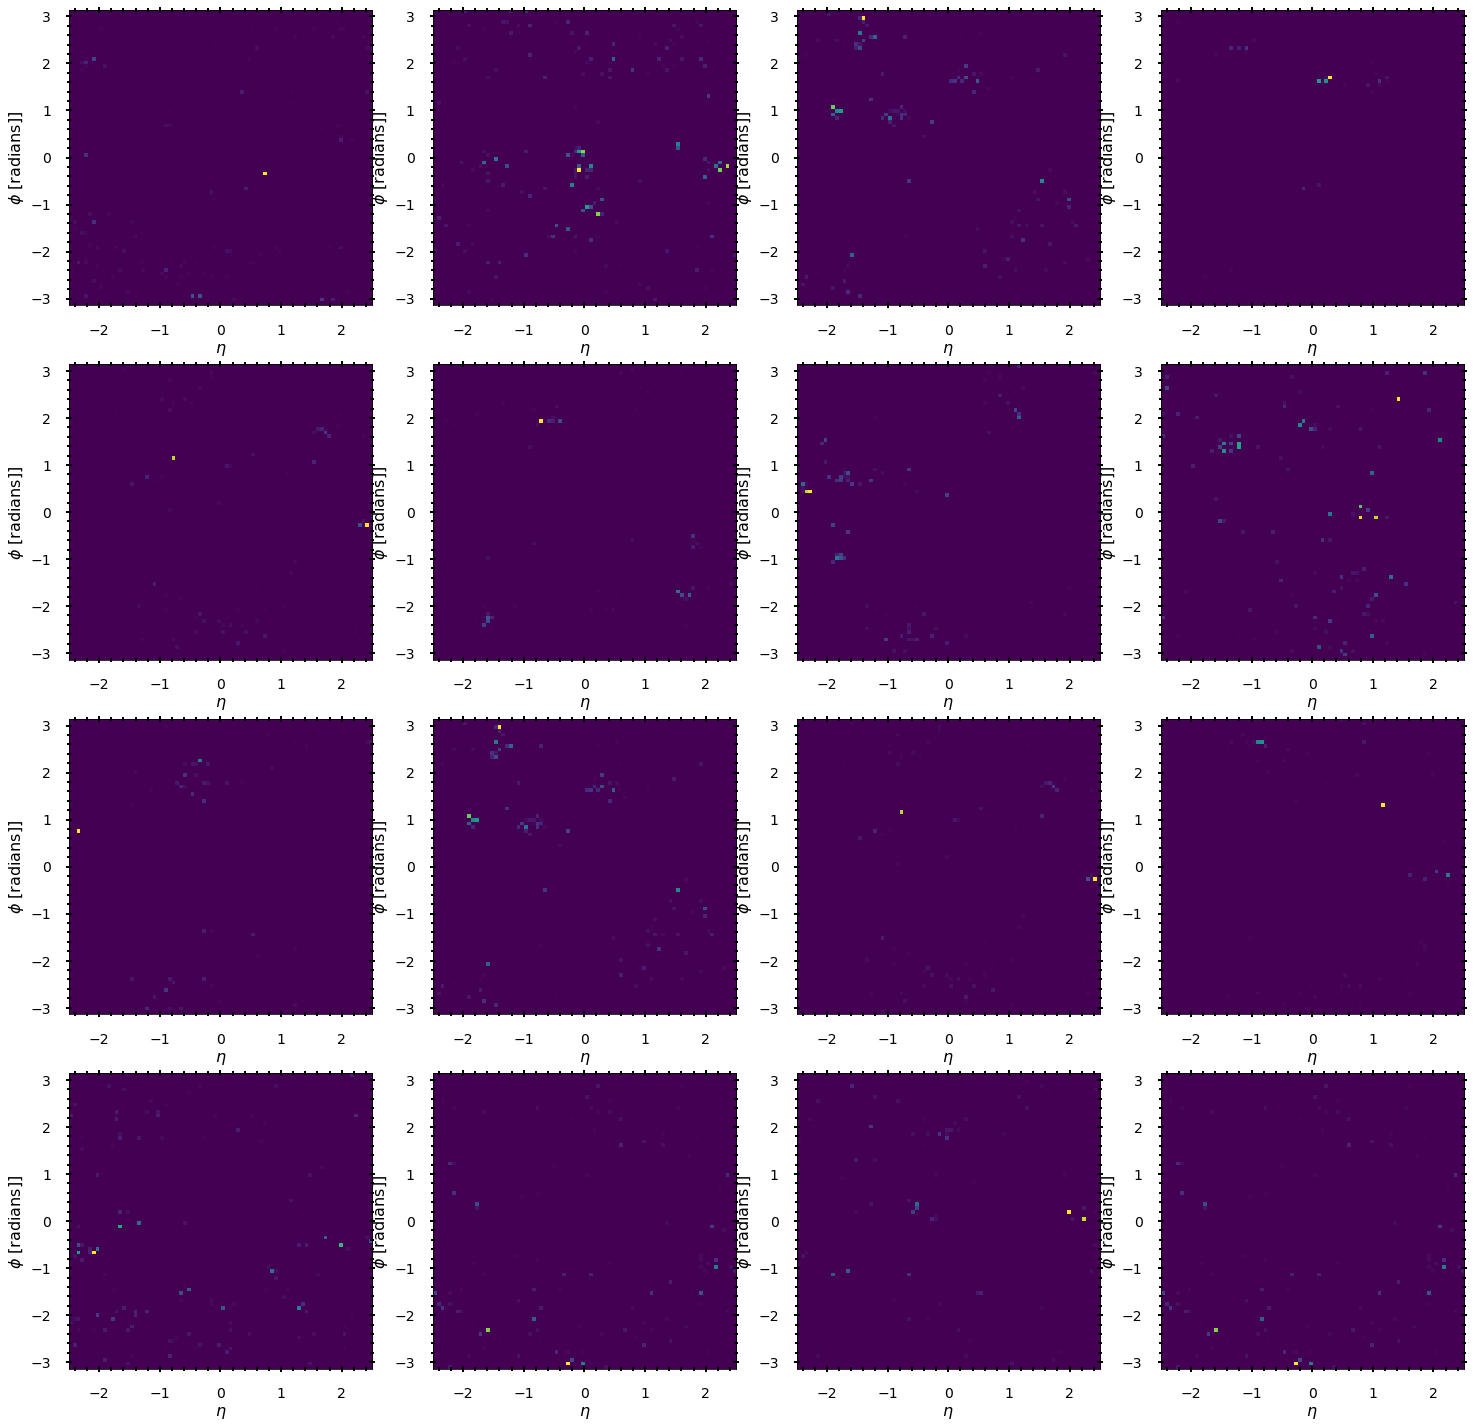

In [39]:
fig, axs = plt.subplots(nrows = 4, ncols = 4, figsize = (25,25))
images = np.random.randint(0, high=len(hists), size=(4,4))
for i in range(4):
    for j in range(4):
        cal_image_plot(axs[i][j])
        axs[i][j].imshow(hists[images[i][j]], extent=[-2.5, 2.5, -np.pi, np.pi], aspect='auto')